In [1]:
# required imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

%matplotlib inline

# Reading the dataset in a dataframe using Pandas

df = pd.read_csv("train.csv")

In [2]:
# preview first 5 rows

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# dataset summary

df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [4]:
# Property area unique value count

df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

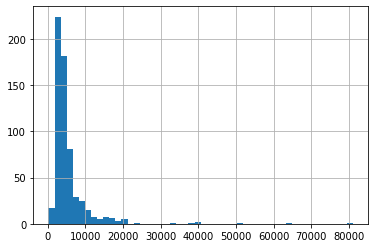

In [5]:
# Histogram for Applicant Income (to understand the data distribution)

df['ApplicantIncome'].hist(bins=50)

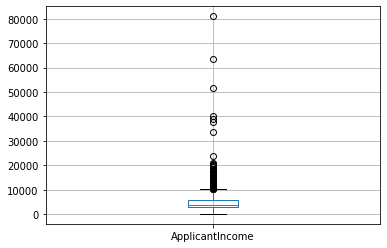

In [6]:
# Box plot (to view outliers)

df.boxplot('ApplicantIncome')

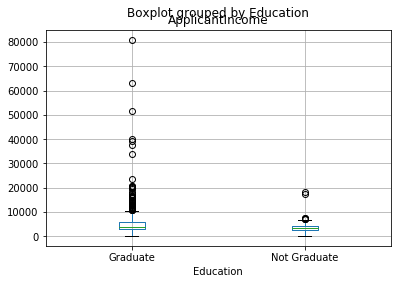

In [7]:
# Box plot for Applicant Income by Education

df.boxplot(column='ApplicantIncome', by='Education')

We can see that the Educated people earn more than the UnEducated

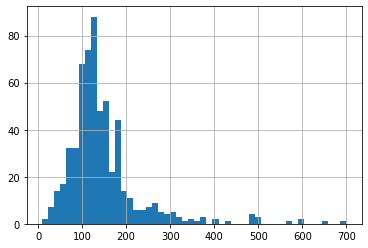

In [8]:
# Histogram for Loan Amount

df.LoanAmount.hist(bins=50)

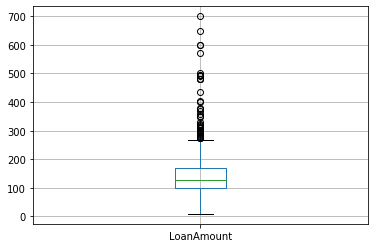

In [9]:
# Loan Amount Box plot

df.boxplot('LoanAmount')

In [10]:
# Class count for Credit History

temp1 = df['Credit_History'].value_counts(ascending=True)
temp1

0.0     89
1.0    475
Name: Credit_History, dtype: int64

In [11]:
# Pivot Table of Loan Status for both classes(0 & 1)

temp2 = df.pivot_table(values='Loan_Status', index=['Credit_History'], aggfunc=lambda x : x.map({'Y':1,'N':0}).mean())
temp2

,Loan_Status
Credit_History,
0.0,0.078652
1.0,0.795789


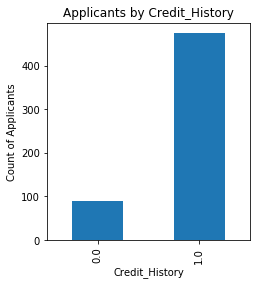

In [12]:
# Visualize Credit History ordered by count of Applicants

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

/home/yaser/anaconda3/envs/MLPracs/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1, 'Probability of getting loan by credit history')

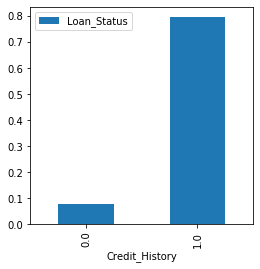

In [13]:
# Visualize Credit History ordered by Loan Status

ax2 = fig.add_subplot(121)
temp2.plot.bar(figsize=(4,4))
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")


Loan_Status      N    Y
Credit_History         
0.0             82    7
1.0             97  378


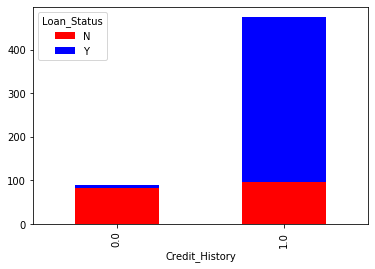

In [14]:
# A cross table of Credit History and Loan Status

temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
print(temp3)
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [15]:
# Impute missing values

df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Self_Employed'].fillna('No',inplace=True)

df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [16]:
# String columns to Categorical

from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

In [17]:
# Generic function for making a classification model and accessing performance:

def classification_model(model, data, predictors, outcome):
    # Fit the model:
    model.fit(data[predictors],data[outcome])

    # Make predictions on training set:
    predictions = model.predict(data[predictors])

    # Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

    # Perform k-fold cross-validation with 5 folds
    print('shape = ',data.shape[0])
    kf = KFold(5)
    kf.get_n_splits(data)
    error = []
    for train, test in kf.split(data):
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    # Fit the model again so that it can be refered outside the function:
    # model.fit(data[predictors],data[outcome])

In [18]:
# Logistic Regression metrics

outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
shape =  614
Cross-Validation Score : 80.946%


In [19]:
# Logistic Regression using few features

predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
shape =  614
Cross-Validation Score : 80.946%


In [20]:
# Decision trees

model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
shape =  614
Cross-Validation Score : 80.946%


In [21]:
# Decision Trees using few features

predictor_var = ['Credit_History','Loan_Amount_Term']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 81.270%
shape =  614
Cross-Validation Score : 80.295%


In [22]:
# Random Forest

model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 86.156%
shape =  614
Cross-Validation Score : 77.529%


In [23]:
# View feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.438510
Dependents          0.131471
Property_Area       0.123489
Loan_Amount_Term    0.110193
Education           0.056123
Married             0.051055
Self_Employed       0.046892
Gender              0.042266
dtype: float64


In [24]:
# Randon Forest with important Features

model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['Dependents','Loan_Amount_Term', 'Credit_History', 'Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 81.433%
shape =  614
Cross-Validation Score : 80.782%
